In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)                        

In [4]:
dataiter = iter(data_loader)
images, labels = dataiter.__next__()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [5]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Input [-1, +1] -> use nn.Tanh

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 24, 3, stride=1, padding=1),
            nn.ReLU(), # -> N, 32, 14, 14
            nn.Conv2d(24, 32, 3, stride=1, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 48, 3, stride=1, padding=1), # -> N, 64, 7, 7
            nn.ReLU(),
            nn.Conv2d(48, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 48, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(48, 32, 3, stride=1, padding=1, output_padding=0), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 24, 3, stride=1, padding=1, output_padding=0), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(24, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        ) #AJUSTAR stride DEPENDIENDO DE LA DIMENSION DE LAS IMAGENES

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [7]:
model = Autoencoder()
#model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [8]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        #img = img.reshape(-1, 28*28)# -> use for Autoencoder_Linear (cambiar tamaño según factor de reducción)
        reduced_img = nn.functional.interpolate(img, scale_factor=0.25, mode='bilinear', align_corners=False) # -> use for Autoencoder
        #reduced_img = img.reshape(-1, 7*7) # -> use for Autoencoder_Linear
        recon = model(reduced_img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.1121
Epoch:2, Loss:0.0745
Epoch:3, Loss:0.0237
Epoch:4, Loss:0.0222
Epoch:5, Loss:0.0197
Epoch:6, Loss:0.0174
Epoch:7, Loss:0.0179
Epoch:8, Loss:0.0150
Epoch:9, Loss:0.0162
Epoch:10, Loss:0.0165


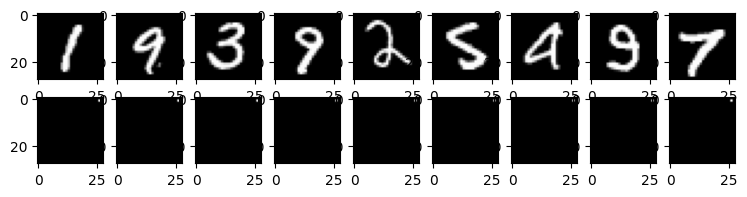

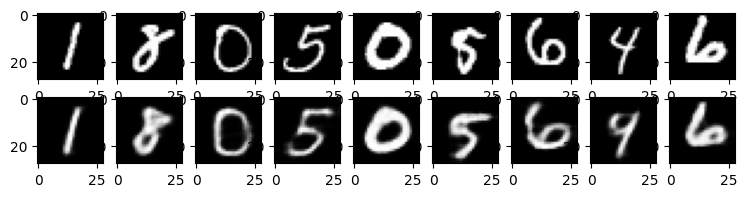

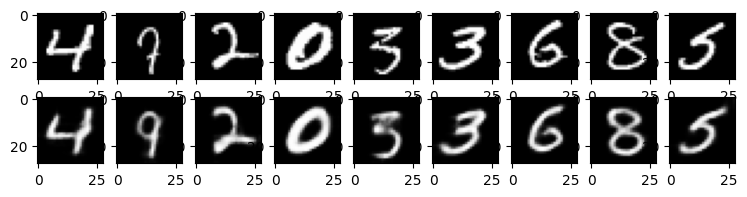

In [9]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        #item = item.reshape(-1, 7, 7) # -> use for Autoencoder_Linear
        #item = item.reshape(-1, 28, 28)
        # item: 1, 28, 28
        plt.imshow(item[0])

## Pruebas sobre el conjunto de validación

Average SSIM: 0.8547878564573314


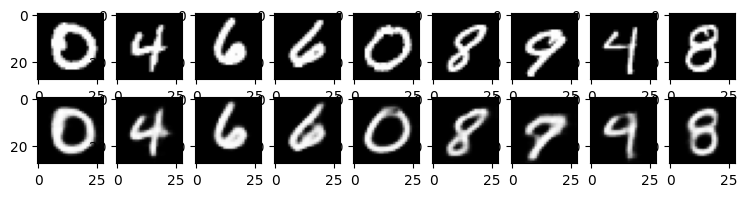

In [10]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = dataiter.__next__()

img = images[0]

plt.figure(figsize=(9, 2))
plt.gray()

ssim_values = []
for i, img in enumerate(images[:9]):
    with torch.no_grad():
        #img2 = img.reshape(-1, 7*7) # -> use for Autoencoder_Linear
        reduced_img = nn.functional.interpolate(img.unsqueeze(0), scale_factor=0.25, mode='bilinear', align_corners=False)
        reduced_img = reduced_img.squeeze(0)
        img2 = reduced_img # -> use for Autoencoder
        #img2 = img
        pred = model(img2)
        recon = pred[0].detach().numpy()
        #recon2 = recon.reshape(-1, 7, 7) # -> use for Autoencoder_Linear
        #recon2 = recon2.reshape(-1, 28, 28)
        ssim_score, _ = ssim(img[0].numpy(), recon, full=True, data_range=1.0)
        ssim_values.append(ssim_score)

        plt.subplot(2, 9, i+1)
        plt.imshow(img[0])

        plt.subplot(2, 9, i+1+9)
        #plt.imshow(recon2[0]) # -> use for Autoencoder_Linear
        plt.imshow(recon) # -> use for Autoencoder
print(f'Mean SSIM Score: {np.mean(ssim_values):.4f}')
plt.show()


### Ejercicios

- Crea un supresor de ruido de imágenes. Añade ruido a las imágenes de entrada y compáralas a la salida con las originales. Varía los hiperparámetros y busca el mejor supresor.

